# Introduction


### Level 1

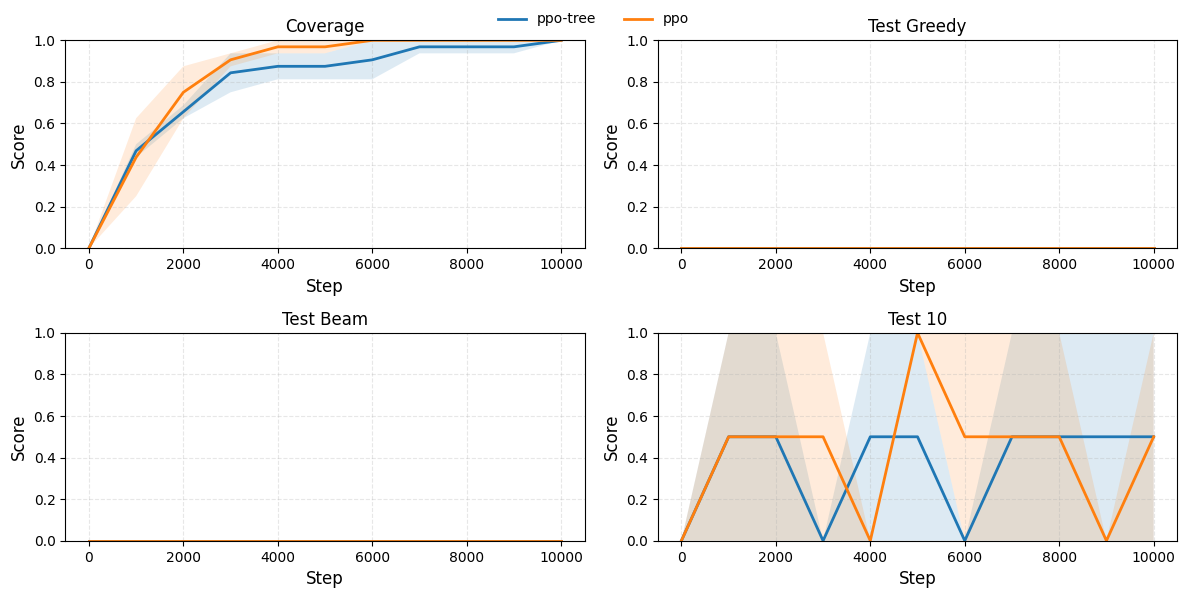

In [6]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# Point this at the root folder that contains agent subfolders (which contain seed subfolders):
# e.g. "data/abel_level1_hidden_dim64"
ROOT = "data/abel_level1_hidden_dim64"

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
root = Path(ROOT)
if not root.exists():
    raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

# Find all learning_curves.csv files recursively
curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
if not curve_files:
    raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

# Build {agent: [df_seed_1, df_seed_2, ...]}
by_agent = {}
for f in curve_files:
    p = Path(f)
    # Assume path like: ROOT / <agent> / seedXXXX / learning_curves.csv
    # agent is the parent folder of the seed folder
    if p.parent.name.startswith("seed"):
        agent = p.parent.parent.name
    else:
        # fallback: take direct parent as agent
        agent = p.parent.name

    if AGENTS_FILTER and agent not in AGENTS_FILTER:
        continue

    df = pd.read_csv(f)
    # Normalize expected columns
    # Some older logs might use 'test_acc' for greedy:
    if "test_greedy" not in df.columns and "test_acc" in df.columns:
        df = df.rename(columns={"test_acc": "test_greedy"})
    # Ensure test_at10 exists if named slightly differently
    if "test_at10" not in df.columns and "test_10" in df.columns:
        df = df.rename(columns={"test_10": "test_at10"})

    # Keep only the relevant columns if present
    keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
    df = df[keep_cols].copy()

    by_agent.setdefault(agent, []).append(df)

if not by_agent:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
# For each agent: align by step, then compute mean & std across seeds
agg = {}  # {agent: DataFrame with columns step, metric_mean, metric_std}
for agent, dfs in by_agent.items():
    # Outer-merge on 'step' with suffixes to keep seeds distinct
    # Then compute row-wise mean/std across the seed columns for each metric
    # Easier approach: reindex all on step, join, then aggregate.
    # First, standardize index to step
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        # Ensure all metrics exist as columns; if missing, fill with NaN so mean/std handle it
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[ [csv for _, csv in METRICS] ]  # order
        # Add a seed-level multi-index to avoid collisions (optional)
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    # Align on step via outer join
    big = pd.concat(indexed, axis=1).sort_index()
    # For each metric, compute mean/std across seed level
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]  # all seeds for this metric
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[agent] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
axes = axes.ravel()
titles = ["coverage", "test_greedy", "test_beam", "test_10"]

for ax, (plot_name, _) in zip(axes, METRICS):
    for agent, df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        ax.plot(x, y, label=agent, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

#fig.suptitle(f"Training Curves from: {Path(ROOT).resolve()}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Level 3

In [9]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# Point this at the root folder that contains agent subfolders (which contain seed subfolders):
# e.g. "data/abel_level1_hidden_dim64"
ROOT = "data/abel_level3_hidden_dim64"

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
root = Path(ROOT)
if not root.exists():
    raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

# Find all learning_curves.csv files recursively
curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
if not curve_files:
    raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

# Build {agent: [df_seed_1, df_seed_2, ...]}
by_agent = {}
for f in curve_files:
    p = Path(f)
    # Assume path like: ROOT / <agent> / seedXXXX / learning_curves.csv
    # agent is the parent folder of the seed folder
    if p.parent.name.startswith("seed"):
        agent = p.parent.parent.name
    else:
        # fallback: take direct parent as agent
        agent = p.parent.name

    if AGENTS_FILTER and agent not in AGENTS_FILTER:
        continue

    df = pd.read_csv(f)
    # Normalize expected columns
    # Some older logs might use 'test_acc' for greedy:
    if "test_greedy" not in df.columns and "test_acc" in df.columns:
        df = df.rename(columns={"test_acc": "test_greedy"})
    # Ensure test_at10 exists if named slightly differently
    if "test_at10" not in df.columns and "test_10" in df.columns:
        df = df.rename(columns={"test_10": "test_at10"})

    # Keep only the relevant columns if present
    keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
    df = df[keep_cols].copy()

    by_agent.setdefault(agent, []).append(df)

if not by_agent:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
# For each agent: align by step, then compute mean & std across seeds
agg = {}  # {agent: DataFrame with columns step, metric_mean, metric_std}
for agent, dfs in by_agent.items():
    # Outer-merge on 'step' with suffixes to keep seeds distinct
    # Then compute row-wise mean/std across the seed columns for each metric
    # Easier approach: reindex all on step, join, then aggregate.
    # First, standardize index to step
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        # Ensure all metrics exist as columns; if missing, fill with NaN so mean/std handle it
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[ [csv for _, csv in METRICS] ]  # order
        # Add a seed-level multi-index to avoid collisions (optional)
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    # Align on step via outer join
    big = pd.concat(indexed, axis=1).sort_index()
    # For each metric, compute mean/std across seed level
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]  # all seeds for this metric
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[agent] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)
axes = axes.ravel()
titles = ["coverage", "test_greedy", "test_beam", "test_10"]

for ax, (plot_name, _) in zip(axes, METRICS):
    for agent, df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        ax.plot(x, y, label=agent, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

#fig.suptitle(f"Training Curves from: {Path(ROOT).resolve()}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

FileNotFoundError: ROOT path not found: /Users/Kev/Documents/research/abel-rl-v3/data/abel_level3_hidden_dim64

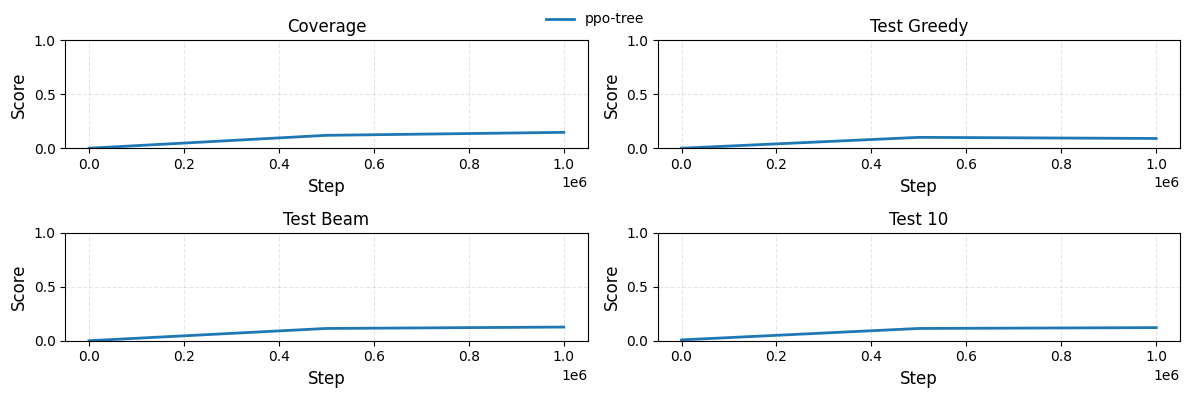

In [ ]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# Point this at the root folder that contains agent subfolders (which contain seed subfolders):
# e.g. "data/abel_level1_hidden_dim64"
ROOT = "data/abel_level3_hidden_dim64_nenvs1"

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
root = Path(ROOT)
if not root.exists():
    raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

# Find all learning_curves.csv files recursively
curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
if not curve_files:
    raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

# Build {agent: [df_seed_1, df_seed_2, ...]}
by_agent = {}
for f in curve_files:
    p = Path(f)
    # Assume path like: ROOT / <agent> / seedXXXX / learning_curves.csv
    # agent is the parent folder of the seed folder
    if p.parent.name.startswith("seed"):
        agent = p.parent.parent.name
    else:
        # fallback: take direct parent as agent
        agent = p.parent.name

    if AGENTS_FILTER and agent not in AGENTS_FILTER:
        continue

    df = pd.read_csv(f)
    # Normalize expected columns
    # Some older logs might use 'test_acc' for greedy:
    if "test_greedy" not in df.columns and "test_acc" in df.columns:
        df = df.rename(columns={"test_acc": "test_greedy"})
    # Ensure test_at10 exists if named slightly differently
    if "test_at10" not in df.columns and "test_10" in df.columns:
        df = df.rename(columns={"test_10": "test_at10"})

    # Keep only the relevant columns if present
    keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
    df = df[keep_cols].copy()

    by_agent.setdefault(agent, []).append(df)

if not by_agent:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
# For each agent: align by step, then compute mean & std across seeds
agg = {}  # {agent: DataFrame with columns step, metric_mean, metric_std}
for agent, dfs in by_agent.items():
    # Outer-merge on 'step' with suffixes to keep seeds distinct
    # Then compute row-wise mean/std across the seed columns for each metric
    # Easier approach: reindex all on step, join, then aggregate.
    # First, standardize index to step
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        # Ensure all metrics exist as columns; if missing, fill with NaN so mean/std handle it
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[ [csv for _, csv in METRICS] ]  # order
        # Add a seed-level multi-index to avoid collisions (optional)
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    # Align on step via outer join
    big = pd.concat(indexed, axis=1).sort_index()
    # For each metric, compute mean/std across seed level
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]  # all seeds for this metric
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[agent] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)
axes = axes.ravel()
titles = ["coverage", "test_greedy", "test_beam", "test_10"]

for ax, (plot_name, _) in zip(axes, METRICS):
    for agent, df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        ax.plot(x, y, label=agent, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

#fig.suptitle(f"Training Curves from: {Path(ROOT).resolve()}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Level 4

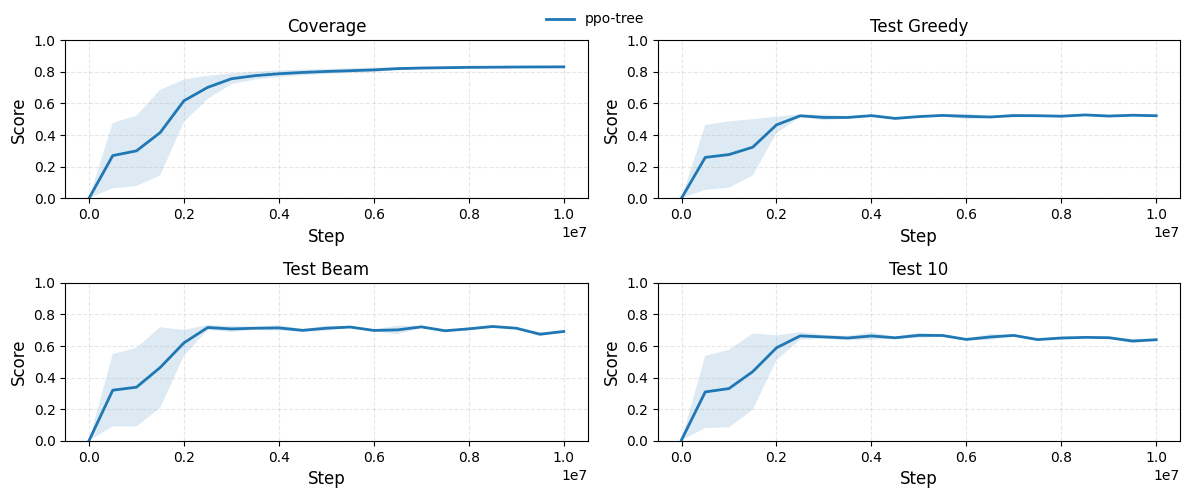

In [4]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# Point this at the root folder that contains agent subfolders (which contain seed subfolders):
# e.g. "data/abel_level1_hidden_dim64"
ROOT = "data/abel_level4_hidden_dim64_nenvs1"

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
root = Path(ROOT)
if not root.exists():
    raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

# Find all learning_curves.csv files recursively
curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
if not curve_files:
    raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

# Build {agent: [df_seed_1, df_seed_2, ...]}
by_agent = {}
for f in curve_files:
    p = Path(f)
    # Assume path like: ROOT / <agent> / seedXXXX / learning_curves.csv
    # agent is the parent folder of the seed folder
    if p.parent.name.startswith("seed"):
        agent = p.parent.parent.name
    else:
        # fallback: take direct parent as agent
        agent = p.parent.name

    if AGENTS_FILTER and agent not in AGENTS_FILTER:
        continue

    df = pd.read_csv(f)
    # Normalize expected columns
    # Some older logs might use 'test_acc' for greedy:
    if "test_greedy" not in df.columns and "test_acc" in df.columns:
        df = df.rename(columns={"test_acc": "test_greedy"})
    # Ensure test_at10 exists if named slightly differently
    if "test_at10" not in df.columns and "test_10" in df.columns:
        df = df.rename(columns={"test_10": "test_at10"})

    # Keep only the relevant columns if present
    keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
    df = df[keep_cols].copy()

    by_agent.setdefault(agent, []).append(df)

if not by_agent:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
# For each agent: align by step, then compute mean & std across seeds
agg = {}  # {agent: DataFrame with columns step, metric_mean, metric_std}
for agent, dfs in by_agent.items():
    # Outer-merge on 'step' with suffixes to keep seeds distinct
    # Then compute row-wise mean/std across the seed columns for each metric
    # Easier approach: reindex all on step, join, then aggregate.
    # First, standardize index to step
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        # Ensure all metrics exist as columns; if missing, fill with NaN so mean/std handle it
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[ [csv for _, csv in METRICS] ]  # order
        # Add a seed-level multi-index to avoid collisions (optional)
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    # Align on step via outer join
    big = pd.concat(indexed, axis=1).sort_index()
    # For each metric, compute mean/std across seed level
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]  # all seeds for this metric
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[agent] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
axes = axes.ravel()
titles = ["coverage", "test_greedy", "test_beam", "test_10"]

for ax, (plot_name, _) in zip(axes, METRICS):
    for agent, df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        ax.plot(x, y, label=agent, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

#fig.suptitle(f"Training Curves from: {Path(ROOT).resolve()}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

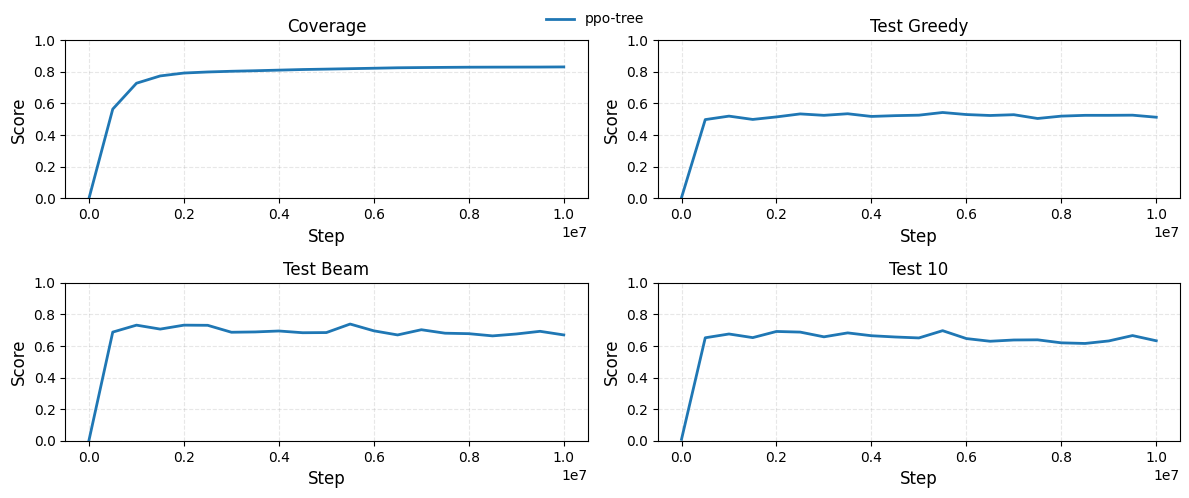

In [8]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# Point this at the root folder that contains agent subfolders (which contain seed subfolders):
# e.g. "data/abel_level1_hidden_dim64"
ROOT = "data/abel_level4_hidden_dim256_nenvs1"

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
root = Path(ROOT)
if not root.exists():
    raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

# Find all learning_curves.csv files recursively
curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
if not curve_files:
    raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

# Build {agent: [df_seed_1, df_seed_2, ...]}
by_agent = {}
for f in curve_files:
    p = Path(f)
    # Assume path like: ROOT / <agent> / seedXXXX / learning_curves.csv
    # agent is the parent folder of the seed folder
    if p.parent.name.startswith("seed"):
        agent = p.parent.parent.name
    else:
        # fallback: take direct parent as agent
        agent = p.parent.name

    if AGENTS_FILTER and agent not in AGENTS_FILTER:
        continue

    df = pd.read_csv(f)
    # Normalize expected columns
    # Some older logs might use 'test_acc' for greedy:
    if "test_greedy" not in df.columns and "test_acc" in df.columns:
        df = df.rename(columns={"test_acc": "test_greedy"})
    # Ensure test_at10 exists if named slightly differently
    if "test_at10" not in df.columns and "test_10" in df.columns:
        df = df.rename(columns={"test_10": "test_at10"})

    # Keep only the relevant columns if present
    keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
    df = df[keep_cols].copy()

    by_agent.setdefault(agent, []).append(df)

if not by_agent:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
# For each agent: align by step, then compute mean & std across seeds
agg = {}  # {agent: DataFrame with columns step, metric_mean, metric_std}
for agent, dfs in by_agent.items():
    # Outer-merge on 'step' with suffixes to keep seeds distinct
    # Then compute row-wise mean/std across the seed columns for each metric
    # Easier approach: reindex all on step, join, then aggregate.
    # First, standardize index to step
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        # Ensure all metrics exist as columns; if missing, fill with NaN so mean/std handle it
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[ [csv for _, csv in METRICS] ]  # order
        # Add a seed-level multi-index to avoid collisions (optional)
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    # Align on step via outer join
    big = pd.concat(indexed, axis=1).sort_index()
    # For each metric, compute mean/std across seed level
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]  # all seeds for this metric
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[agent] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
axes = axes.ravel()
titles = ["coverage", "test_greedy", "test_beam", "test_10"]

for ax, (plot_name, _) in zip(axes, METRICS):
    for agent, df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        ax.plot(x, y, label=agent, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

#fig.suptitle(f"Training Curves from: {Path(ROOT).resolve()}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Look at n_envs = 1,2 here

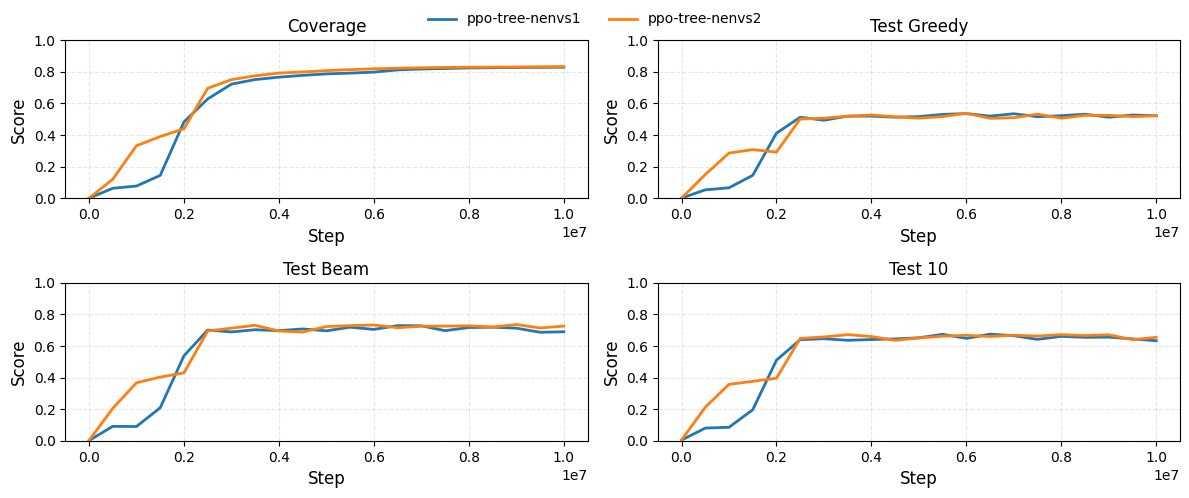

In [9]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# List of experiment roots you want to compare:
ROOTS = {
    "nenvs1": "data/abel_level4_hidden_dim64_nenvs1",
    "nenvs2": "data/abel_level4_hidden_dim64_nenvs2",
}

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
by_agent_cfg = {}  # {(agent, cfg): [dfs...]}

for cfg_name, root_path in ROOTS.items():
    root = Path(root_path)
    if not root.exists():
        raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

    curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
    if not curve_files:
        raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

    for f in curve_files:
        p = Path(f)
        if p.parent.name.startswith("seed"):
            agent = p.parent.parent.name
        else:
            agent = p.parent.name
        if AGENTS_FILTER and agent not in AGENTS_FILTER:
            continue

        df = pd.read_csv(f)
        if "test_greedy" not in df.columns and "test_acc" in df.columns:
            df = df.rename(columns={"test_acc": "test_greedy"})
        if "test_at10" not in df.columns and "test_10" in df.columns:
            df = df.rename(columns={"test_10": "test_at10"})

        keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
        df = df[keep_cols].copy()

        by_agent_cfg.setdefault((agent, cfg_name), []).append(df)

if not by_agent_cfg:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
agg = {}  # {(agent, cfg): DataFrame}
for (agent, cfg), dfs in by_agent_cfg.items():
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[[csv for _, csv in METRICS]]
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    big = pd.concat(indexed, axis=1).sort_index()
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[(agent, cfg)] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
axes = axes.ravel()

for ax, (plot_name, _) in zip(axes, METRICS):
    for (agent, cfg), df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        label = f"{agent}-{cfg}"
        ax.plot(x, y, label=label, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

plt.tight_layout()
plt.show()

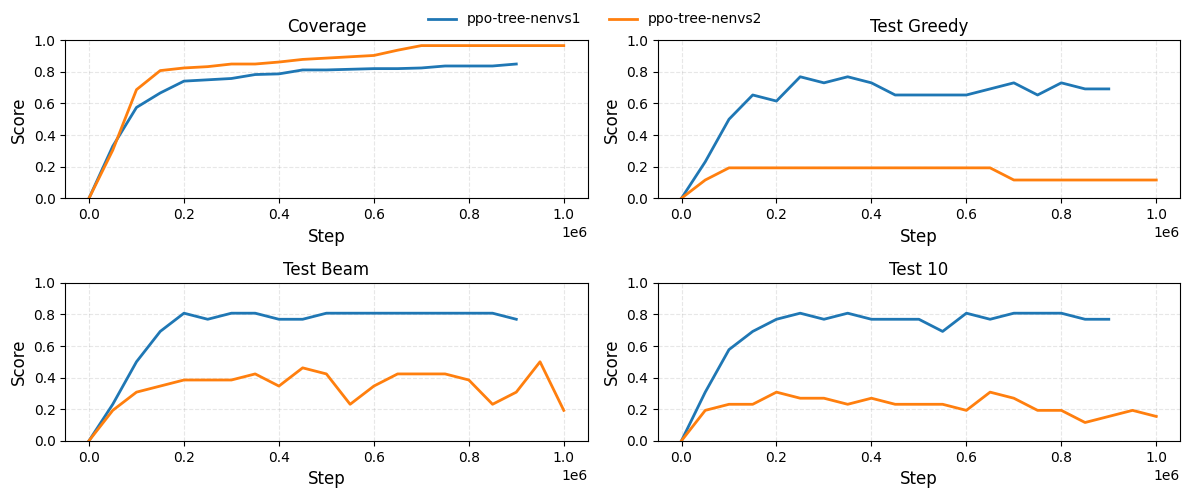

In [10]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# List of experiment roots you want to compare:
ROOTS = {
    "nenvs1": "data/abel_level2_hidden_dim64_nenvs1",
    "nenvs2": "data/abel_level2_hidden_dim64_nenvs2",
}

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
by_agent_cfg = {}  # {(agent, cfg): [dfs...]}

for cfg_name, root_path in ROOTS.items():
    root = Path(root_path)
    if not root.exists():
        raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

    curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
    if not curve_files:
        raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

    for f in curve_files:
        p = Path(f)
        if p.parent.name.startswith("seed"):
            agent = p.parent.parent.name
        else:
            agent = p.parent.name
        if AGENTS_FILTER and agent not in AGENTS_FILTER:
            continue

        df = pd.read_csv(f)
        if "test_greedy" not in df.columns and "test_acc" in df.columns:
            df = df.rename(columns={"test_acc": "test_greedy"})
        if "test_at10" not in df.columns and "test_10" in df.columns:
            df = df.rename(columns={"test_10": "test_at10"})

        keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
        df = df[keep_cols].copy()

        by_agent_cfg.setdefault((agent, cfg_name), []).append(df)

if not by_agent_cfg:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
agg = {}  # {(agent, cfg): DataFrame}
for (agent, cfg), dfs in by_agent_cfg.items():
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[[csv for _, csv in METRICS]]
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    big = pd.concat(indexed, axis=1).sort_index()
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[(agent, cfg)] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
axes = axes.ravel()

for ax, (plot_name, _) in zip(axes, METRICS):
    for (agent, cfg), df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        label = f"{agent}-{cfg}"
        ax.plot(x, y, label=label, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

plt.tight_layout()
plt.show()

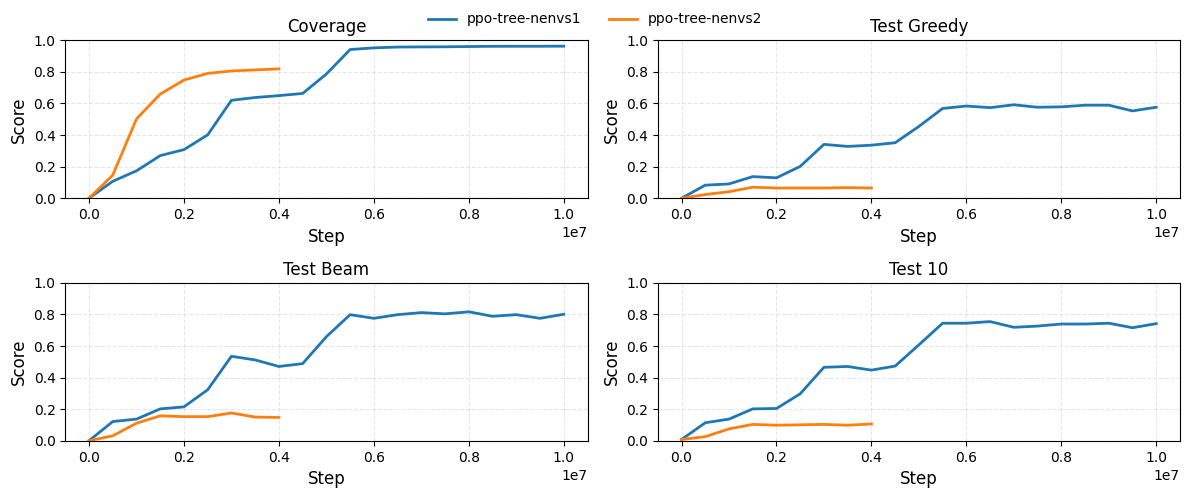

In [1]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
# List of experiment roots you want to compare:
ROOTS = {
    "nenvs1": "data/abel_level3_hidden_dim64_nenvs1",
    "nenvs2": "data/abel_level3_hidden_dim64_nenvs2",
}

# Optional: restrict to specific agents (None = plot all found)
AGENTS_FILTER = None  # e.g. ["ppo", "ppo-tree"]

# Metrics to plot and their column names in CSV
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),  # CSV uses 'test_at10'; we label it 'test_10' on the plot
]

# ---------- LOAD ----------
by_agent_cfg = {}  # {(agent, cfg): [dfs...]}

for cfg_name, root_path in ROOTS.items():
    root = Path(root_path)
    if not root.exists():
        raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

    curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
    if not curve_files:
        raise FileNotFoundError(f"No learning_curves.csv files found under {root.resolve()}")

    for f in curve_files:
        p = Path(f)
        if p.parent.name.startswith("seed"):
            agent = p.parent.parent.name
        else:
            agent = p.parent.name
        if AGENTS_FILTER and agent not in AGENTS_FILTER:
            continue

        df = pd.read_csv(f)
        if "test_greedy" not in df.columns and "test_acc" in df.columns:
            df = df.rename(columns={"test_acc": "test_greedy"})
        if "test_at10" not in df.columns and "test_10" in df.columns:
            df = df.rename(columns={"test_10": "test_at10"})

        keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
        df = df[keep_cols].copy()

        by_agent_cfg.setdefault((agent, cfg_name), []).append(df)

if not by_agent_cfg:
    raise RuntimeError("No agents matched or no valid CSV columns found to plot.")

# ---------- AGGREGATE ----------
agg = {}  # {(agent, cfg): DataFrame}
for (agent, cfg), dfs in by_agent_cfg.items():
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[[csv for _, csv in METRICS]]
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    big = pd.concat(indexed, axis=1).sort_index()
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)

    out = out.reset_index().rename(columns={"index": "step"})
    agg[(agent, cfg)] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
axes = axes.ravel()

for ax, (plot_name, _) in zip(axes, METRICS):
    for (agent, cfg), df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values if std_col in df.columns else None

        label = f"{agent}-{cfg}"
        ax.plot(x, y, label=label, linewidth=2)
        if s is not None and np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.0])
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

plt.tight_layout()
plt.show()

### Search buffer

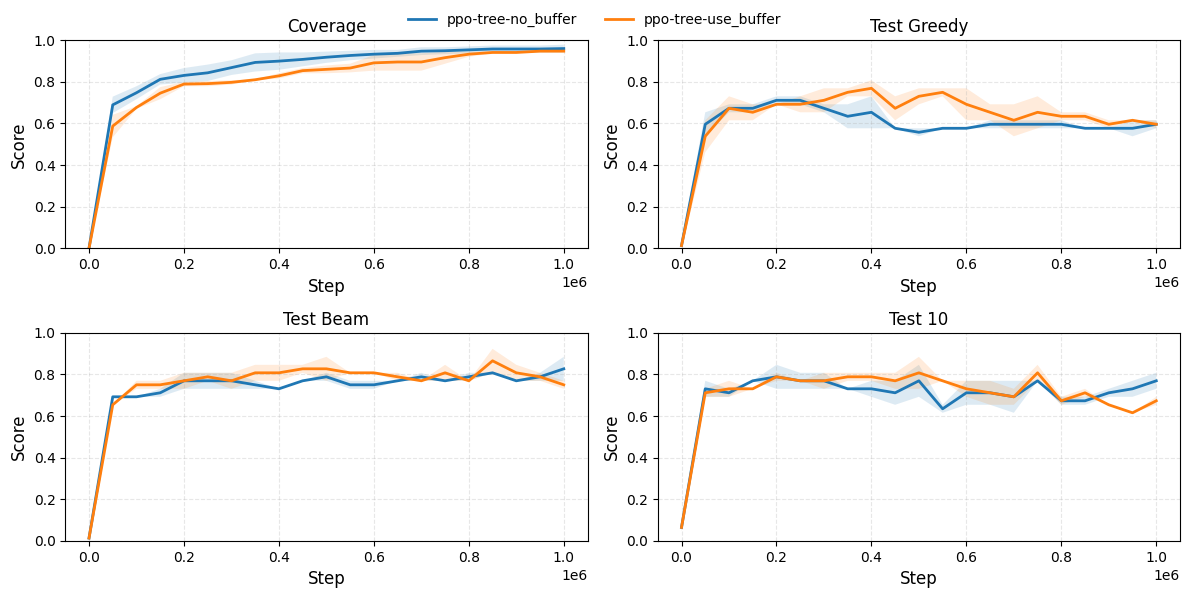

In [41]:
# %matplotlib inline
import os
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
ROOTS = {
    "no_buffer": "data/abel_level2_hidden_dim256_nenvs1",
    "use_buffer": "data/use_buffer/abel_level2_hidden_dim256_nenvs1",
}

AGENTS_FILTER = None  # set to e.g. ["ppo-mem"] if you want to restrict
METRICS = [
    ("coverage",    "coverage"),
    ("test_greedy", "test_greedy"),
    ("test_beam",   "test_beam"),
    ("test_10",     "test_at10"),
]

# ---------- LOAD ----------
by_agent_cfg = {}

for cfg_name, root_path in ROOTS.items():
    root = Path(root_path)
    if not root.exists():
        raise FileNotFoundError(f"ROOT path not found: {root.resolve()}")

    curve_files = glob(str(root / "**" / "learning_curves.csv"), recursive=True)
    if not curve_files:
        raise FileNotFoundError(f"No learning_curves.csv under {root.resolve()}")

    for f in curve_files:
        p = Path(f)
        if p.parent.name.startswith("seed"):
            agent = p.parent.parent.name
        else:
            agent = p.parent.name
        if AGENTS_FILTER and agent not in AGENTS_FILTER:
            continue

        df = pd.read_csv(f)
        if "test_greedy" not in df.columns and "test_acc" in df.columns:
            df = df.rename(columns={"test_acc": "test_greedy"})
        if "test_at10" not in df.columns and "test_10" in df.columns:
            df = df.rename(columns={"test_10": "test_at10"})

        keep_cols = ["step"] + [csv_col for _, csv_col in METRICS if csv_col in df.columns]
        df = df[keep_cols].copy()

        by_agent_cfg.setdefault((agent, cfg_name), []).append(df)

# ---------- AGGREGATE ----------
agg = {}
for (agent, cfg), dfs in by_agent_cfg.items():
    indexed = []
    for i, d in enumerate(dfs):
        d_i = d.set_index("step").sort_index()
        for _, csv_col in METRICS:
            if csv_col not in d_i.columns:
                d_i[csv_col] = np.nan
        d_i = d_i[[csv for _, csv in METRICS]]
        d_i.columns = pd.MultiIndex.from_product([[f"seed{i}"], d_i.columns])
        indexed.append(d_i)

    big = pd.concat(indexed, axis=1).sort_index()
    out = pd.DataFrame(index=big.index)
    for plot_name, csv_col in METRICS:
        cols = [c for c in big.columns if c[1] == csv_col]
        vals = big[cols]
        out[f"{plot_name}_mean"] = vals.mean(axis=1, skipna=True)
        out[f"{plot_name}_std"]  = vals.std(axis=1, ddof=0, skipna=True)
    out = out.reset_index().rename(columns={"index": "step"})
    agg[(agent, cfg)] = out

# ---------- PLOT ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.ravel()

for ax, (plot_name, _) in zip(axes, METRICS):
    for (agent, cfg), df in agg.items():
        mean_col = f"{plot_name}_mean"
        std_col  = f"{plot_name}_std"
        if mean_col not in df.columns:
            continue
        x = df["step"].values
        y = df[mean_col].values
        s = df[std_col].values
        label = f"{agent}-{cfg}"
        ax.plot(x, y, label=label, linewidth=2)
        if np.isfinite(s).any():
            ax.fill_between(x, np.maximum(0, y - s), np.minimum(1, y + s), alpha=0.15)

    ax.set_title(plot_name.replace("_", " ").title())
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.set_ylim([0, 1])
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=min(4, len(labels)), frameon=False)

plt.tight_layout()
plt.show()
